# 3D CNN

In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [2]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v2'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

class_names = ['CN', 'AD']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 32
input_shape = (112, 112, 105, 1)
resize_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 1.2641509433962266, 1: 0.8271604938271606}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
log_dir: ../../tmp/logs/20201213-182225
CPU times: user 2.08 ms, sys: 2.12 ms, total: 4.2 ms
Wall time: 6.77 ms


In [17]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
    'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'tpu': False,
    'model_key': model_key,
    'validation': 'val_test', # validation is val + test
    'epochs': 2,
    'patience': 150,
    'tensorboard_update_freq': 'epoch', 
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': 'save_best_only',
    'batch_size': 1,
#     'model_checkpoint_callback': False,
}

## Train

In [4]:
model = create_model(**model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 18, 17, 128)   2

In [5]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [6]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    val_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201213-182225
checkpoint dir: ../../tmp/checkpoints/20201213-182225
log dir: ../../tmp/logs/20201213-182225
loading ../../tmp/data-v2/train_x.npy, ../../tmp/data-v2/train_y.npy...
loading ../../tmp/data-v2/val_x.npy, ../../tmp/data-v2/val_y.npy...
loading ../../tmp/data-v2/test_x.npy, ../../tmp/data-v2/test_y.npy...
train: 10, val: 4
training on gpu...
Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 1.3284 - recall: 0.7000 - precision: 0.7000 - auc: 0.6900 - categorical_accuracy: 0.7000
Epoch 00001: saving model to ../../tmp/checkpoints/20201213-182225/cp-0001.ckpt
10/10 [==============================] - 57s 6s/step - loss: 1.3284 - recall: 0.7000 - precision: 0.7000 - auc: 0.6900 - categorical_accuracy: 0.7000 - val_loss: 0.5068 - val_recall: 1.0000 - val_precision: 1.0000 - val_auc: 1.0000 - val_categorical_accuracy: 1.0000
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.8642 - recall: 0.7000 - precision: 0.7000 - auc: 0.8300 - ca

## Evaluation

CPU times: user 205 ms, sys: 200 ms, total: 405 ms
Wall time: 413 ms


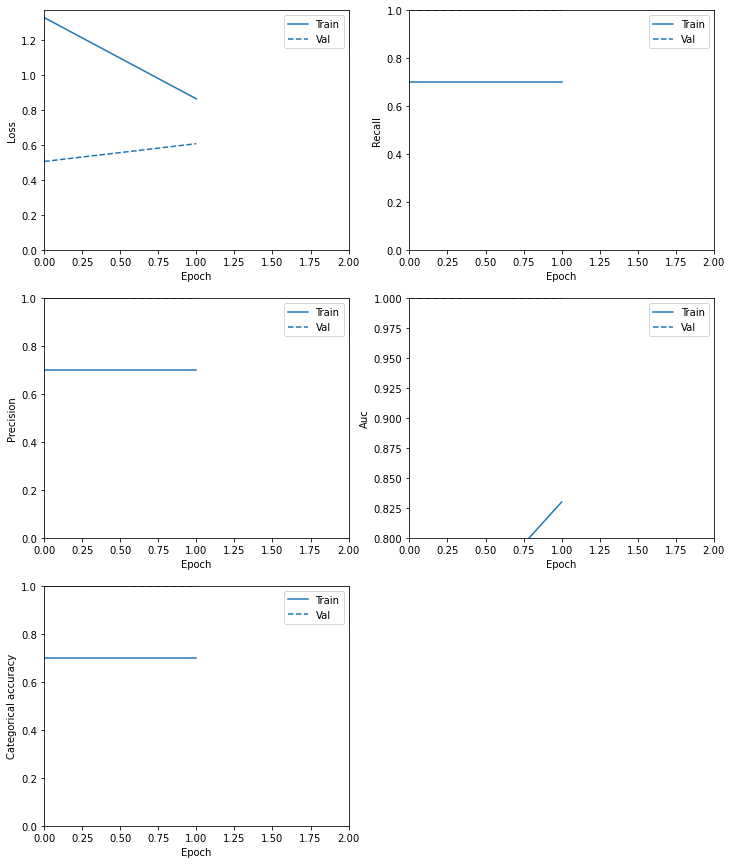

In [12]:
%%time

plot_training_history(history)

In [13]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.6768801212310791
recall: 1.0
precision: 1.0
auc: 1.0
categorical_accuracy: 1.0

CPU times: user 5.04 s, sys: 442 ms, total: 5.48 s
Wall time: 2.08 s


AD
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 2


CN
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 0


micro avg
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 2


macro avg
precision: 0.5
recall: 0.5
f1-score: 0.5
support: 2


weighted avg
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 2


samples avg
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 2


F1
micro: 1.0
macro: 0.5


accuracy_score: 1.0
sensitivity_score: 1.0
specificity_score: 1.0


CPU times: user 4.63 s, sys: 454 ms, total: 5.08 s
Wall time: 1.61 s


/Users/timzatko/opt/anaconda3/envs/dp-timzatko/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/timzatko/opt/anaconda3/envs/dp-timzatko/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/timzatko/opt/anaconda3/envs/dp-timzatko/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predict

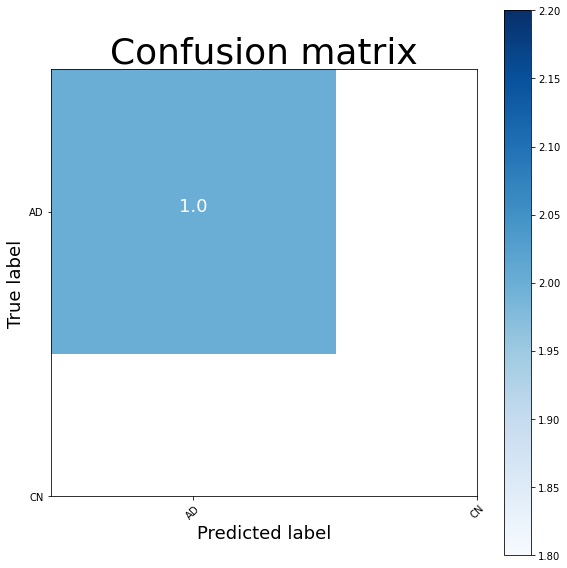

In [16]:
%%time

show_metrics(model, test_seq, class_names)